In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fungsi Edge Detection
def apply_kernel_cv2(img, kernel):
    return cv2.filter2D(img, -1, kernel)

# Dilation
def dilation(img, kernel, iterations=1):
    for _ in range(iterations):
        img = cv2.dilate(img, kernel, iterations=1)
    return img

# Erosion 
def erosion(img, kernel, iterations=1):
    for _ in range(iterations):
        img = cv2.erode(img, kernel, iterations=1)
    return img

# Segmentasi Citra
def segmentation(img_rgb, img_gray, edge_method):
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if edge_method == "prewitt":
        kx = np.array([[1,0,-1], [1,0,-1], [1,0,-1]])
        ky = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
    else:  # sobel
        kx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
        ky = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

    edge_x = apply_kernel_cv2(binary, kx)
    edge_y = apply_kernel_cv2(binary, ky)
    edge = np.sqrt(edge_x**2 + edge_y**2)
    edge = (edge / edge.max() * 255).astype(np.uint8)

    kernel = np.ones((15, 3), dtype=np.uint8)
    morph = erosion(dilation(edge, kernel, iterations=2), kernel, iterations=2)

    H, W = img_gray.shape
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph, connectivity=8)
    mask = np.zeros_like(morph)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > 1000:
            mask[labels == i] = 255

    otsu = np.zeros_like(img_gray)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > 1000:
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            roi = img_gray[y:y+h, x:x+w]
            _, roi_otsu = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            otsu[y:y+h, x:x+w] = roi_otsu

    contours, _ = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        ratio = w / h
        if 0.05 * H * W < area < 0.3 * H * W and 2 < ratio < 5:
            candidates.append((x, y, w, h))

    result_img = img_rgb.copy()
    for x, y, w, h in candidates:
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

    return binary, edge, mask, otsu, result_img

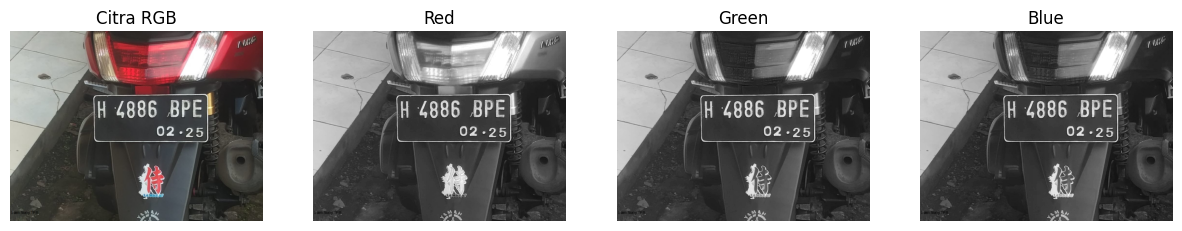

In [3]:
img = cv2.imread('2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
red = img_rgb[:,:,0]
green = img_rgb[:,:,1]
blue = img_rgb[:,:,2]
img_gray = (0.3 * red + 0.5 * green + 0.2 * blue).astype(np.uint8)

# Visualisasi RGB 
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1), plt.imshow(img_rgb), plt.title("Citra RGB"), plt.axis('off')
plt.subplot(1, 4, 2), plt.imshow(red, cmap='gray'), plt.title("Red"), plt.axis('off')
plt.subplot(1, 4, 3), plt.imshow(green, cmap='gray'), plt.title("Green"), plt.axis('off')
plt.subplot(1, 4, 4), plt.imshow(blue, cmap='gray'), plt.title("Blue"), plt.axis('off')
plt.show()

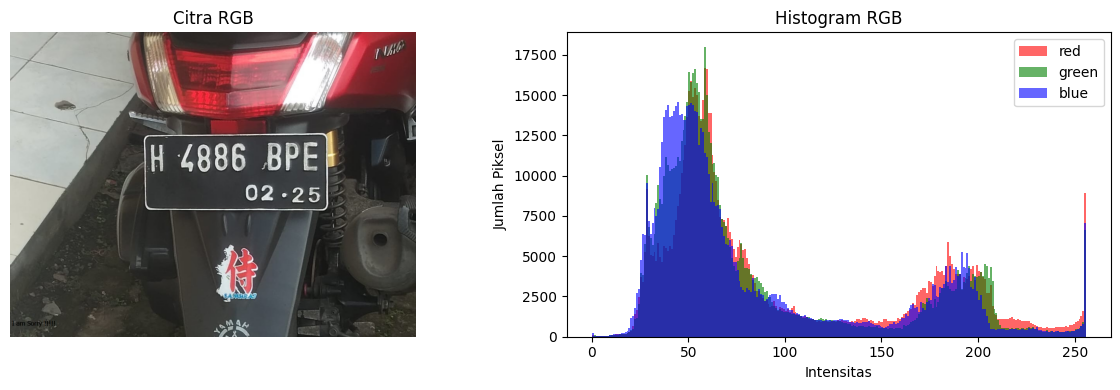

(None, None)

In [4]:
#Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(img_rgb), plt.title("Citra RGB"), plt.axis('off')
plt.subplot(1, 2, 2)
for ch, color in zip([red, green, blue], ['red', 'green', 'blue']):
    plt.hist(ch.ravel(), bins=256, range=(0, 256), color=color, alpha=0.6, label=color)
plt.title("Histogram RGB"), plt.xlabel("Intensitas"), plt.ylabel("Jumlah Piksel"), plt.legend()
plt.tight_layout(), plt.show()

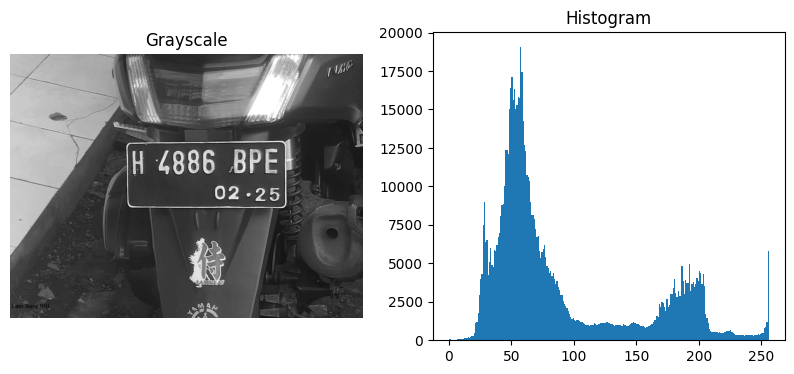

In [5]:
# Histogram Grayscale
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1), plt.imshow(img_gray, cmap='gray'), plt.title("Grayscale"), plt.axis('off')
plt.subplot(1, 2, 2), plt.hist(img_gray.ravel(), bins=256, range=(0,256)), plt.title("Histogram")
plt.show()

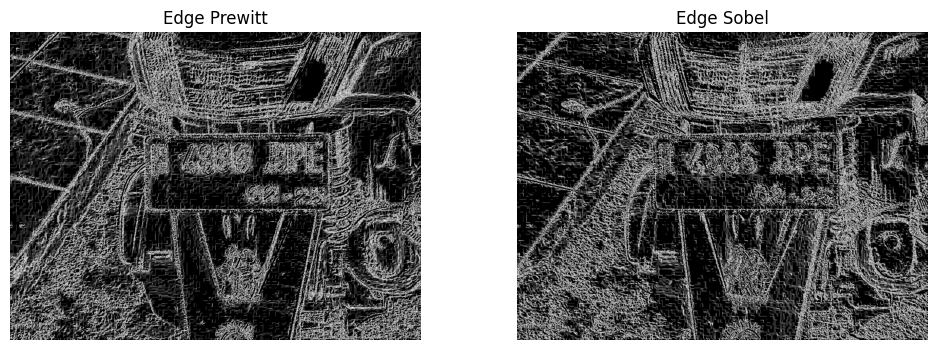

In [6]:
# edge detection
prewitt_kx = np.array([[1,0,-1], [1,0,-1], [1,0,-1]])
prewitt_ky = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
prewitt_x = apply_kernel_cv2(img_gray, prewitt_kx)
prewitt_y = apply_kernel_cv2(img_gray, prewitt_ky)
prewitt = np.sqrt(prewitt_x**2 + prewitt_y**2)
prewitt = (prewitt / prewitt.max() * 255).astype(np.uint8)

sobel_ky = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
sobel_kx = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
sobel_x = apply_kernel_cv2(img_gray, sobel_kx)
sobel_y = apply_kernel_cv2(img_gray, sobel_ky)
sobel = np.sqrt(sobel_x**2 + sobel_y**2)
sobel = (sobel / sobel.max() * 255).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(prewitt, cmap='gray'), plt.title("Edge Prewitt"), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(sobel, cmap='gray'), plt.title("Edge Sobel"), plt.axis('off')
plt.show()

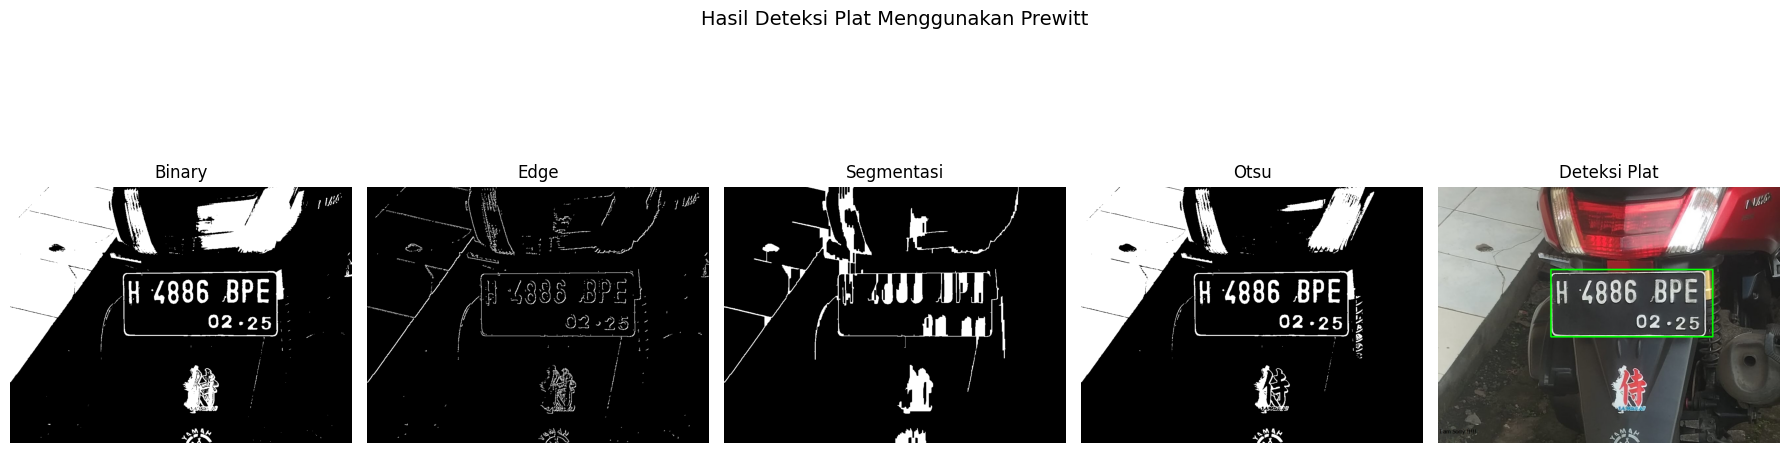

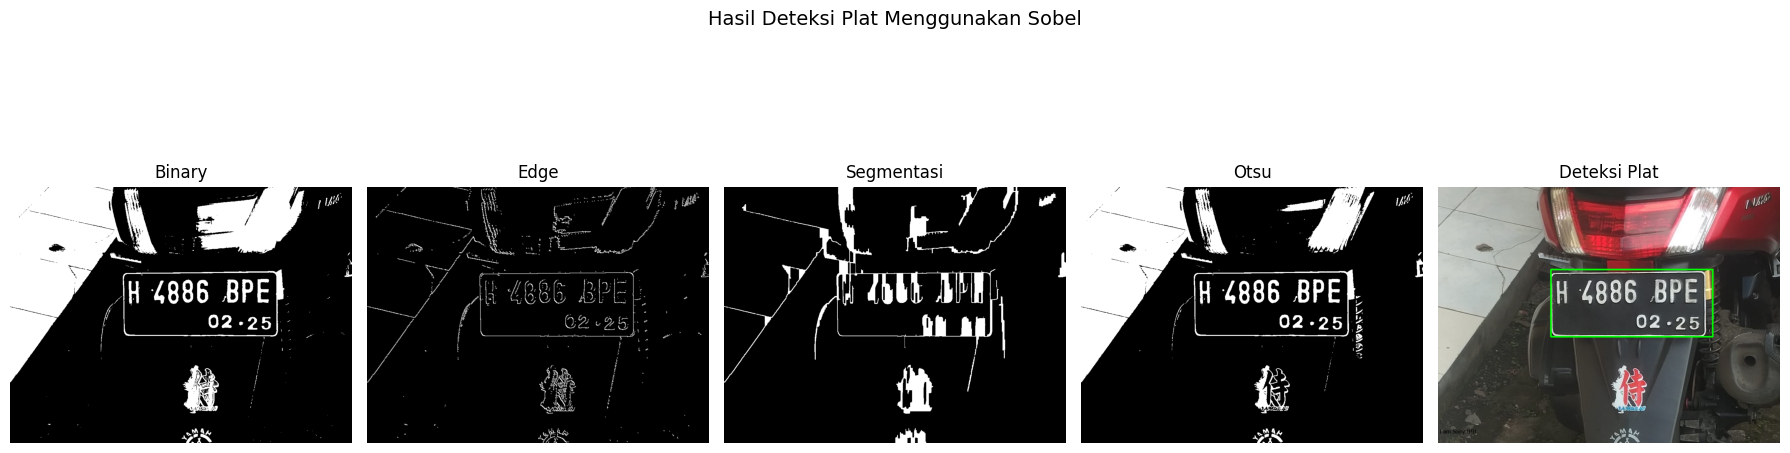

In [7]:
 # Segmentasi dan Deteksi
binary, prewitt_edge, prewitt_mask, prewitt_otsu, prewitt_result = segmentation(img_rgb, img_gray, "prewitt")
_, sobel_edge, sobel_mask, sobel_otsu, sobel_result = segmentation(img_rgb, img_gray, "sobel")

titles = ["Prewitt", "Sobel"]
edges = [prewitt_edge, sobel_edge]
masks = [prewitt_mask, sobel_mask]
otsus = [prewitt_otsu, sobel_otsu]
results = [prewitt_result, sobel_result]

for i in range(2):
    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Hasil Deteksi Plat Menggunakan {titles[i]}", fontsize=14)
    plt.subplot(1, 5, 1), plt.imshow(binary, cmap='gray'), plt.title("Binary"), plt.axis('off')
    plt.subplot(1, 5, 2), plt.imshow(edges[i], cmap='gray'), plt.title("Edge"), plt.axis('off')
    plt.subplot(1, 5, 3), plt.imshow(masks[i], cmap='gray'), plt.title("Segmentasi"), plt.axis('off')
    plt.subplot(1, 5, 4), plt.imshow(otsus[i], cmap='gray'), plt.title("Otsu"), plt.axis('off')
    plt.subplot(1, 5, 5), plt.imshow(results[i]), plt.title("Deteksi Plat"), plt.axis('off')
    plt.tight_layout(), plt.show()